# EDA, Data Cleaning, Modeling, Census 2012

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer

In [2]:
X = pd.read_csv("Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv")
y = pd.read_csv("Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv")
X.shape, y.shape

((59400, 40), (59400, 2))

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [4]:
X.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
y.head(2)

,id,status_group
0,69572,functional
1,8776,functional


## 1. Baseline Accuracy (54.3%)

In [6]:
y["status_group"].value_counts(normalize = True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

## 2. First Model with All 9 Numeric Features

In [7]:
X_num = X.select_dtypes(include="number")

In [8]:
X_num = X_num.drop(columns = "id")

In [9]:
X_num.head(3)

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
0,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999
1,0.0,1399,34.698766,-2.147466,0,20,2,280,2010
2,25.0,686,37.460664,-3.821329,0,21,4,250,2009


In [10]:
y = y["status_group"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y, random_state=42, stratify=y)

In [12]:
ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe1 = Pipeline([("sc", ss), ("clf", logreg)])

pipe1.fit(X_train, y_train)
pipe1.score(X_test, y_test)

0.5582491582491582

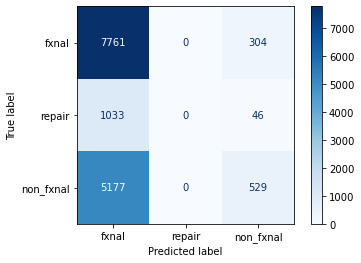

In [13]:
ConfusionMatrixDisplay.from_estimator(pipe1, X_test, y_test, cmap ="Blues", display_labels=["fxnal", "repair", "non_fxnal"]);

> This model is very much the same as the null model which predicts all pumps functional

## 3. Examine Categorical Features (30 total)

### 3.1. date_recorded

In [14]:
X["date_recorded"].value_counts()

2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2011-09-11      1
2011-08-31      1
2011-09-21      1
2011-08-30      1
2013-12-01      1
Name: date_recorded, Length: 356, dtype: int64

> This columns should be converted to datetime data type
>
> Group them by month maybe, to reduce the number of values

### 3.2. funder

In [15]:
X["funder"].value_counts()  #many

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Rarymond Ekura               1
Justine Marwa                1
Municipal Council            1
Afdp                         1
Samlo                        1
Name: funder, Length: 1897, dtype: int64

### 3.3. installer

In [16]:
X["installer"].value_counts()  #many

DWE                17402
Government          1825
RWE                 1206
Commu               1060
DANIDA              1050
                   ...  
Wizara  ya maji        1
TWESS                  1
Nasan workers          1
R                      1
SELEPTA                1
Name: installer, Length: 2145, dtype: int64

### 3.4. wpt_name (waterpoint name)

In [17]:
X["wpt_name"].value_counts()  #too many

none                       3563
Shuleni                    1748
Zahanati                    830
Msikitini                   535
Kanisani                    323
                           ... 
Kwa Medadi                    1
Kwa Kubembeni                 1
Shule Ya Msingi Milanzi       1
Funua                         1
Kwa Mzee Lugawa               1
Name: wpt_name, Length: 37400, dtype: int64

### 3.5. basin, subvillage, region

In [18]:
X["basin"].value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [19]:
X["region"].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [20]:
X["subvillage"].value_counts()  #too many

Madukani        508
Shuleni         506
Majengo         502
Kati            373
Mtakuja         262
               ... 
Kipompo           1
Chanyamilima      1
Ikalime           1
Kemagaka          1
Kikatanyemba      1
Name: subvillage, Length: 19287, dtype: int64

> From big to small: basin > region > subvillage
>
> Probably use region only

### 3.6. ward, lga

> LGA is Local Government Area. Each LGA contains many wards.
>
> Maybe use LGA only (still alot, 125 of them)

In [21]:
X["ward"].value_counts()  #many

Igosi              307
Imalinyi           252
Siha Kati          232
Mdandu             231
Nduruma            217
                  ... 
Uchindile            1
Thawi                1
Uwanja wa Ndege      1
Izia                 1
Kinungu              1
Name: ward, Length: 2092, dtype: int64

In [22]:
X["lga"].value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

### 3.7. public_meeting

In [23]:
X["public_meeting"].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

> Convert to numeric: 1 for True, 0 for False

### 3.8. recorded_by

In [24]:
X["recorded_by"].value_counts()  #only 1 value, not useful

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

### 3.9. scheme_management, scheme_name

In [25]:
X["scheme_management"].value_counts()  #names look similar to management in 3.12

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [26]:
X["scheme_name"].value_counts()   #many names

K                       682
None                    644
Borehole                546
Chalinze wate           405
M                       400
                       ... 
Mradi wa maji Vijini      1
Villagers                 1
Magundi water supply      1
Saadani Chumv             1
Mtawanya                  1
Name: scheme_name, Length: 2696, dtype: int64

### 3.10. permit

In [27]:
X["permit"].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

> Convert to numeric: 1 for True, 0 for False

### 3.11. extraction_type, extraction_type_group, extraction_type_class

In [28]:
X["extraction_type"].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [29]:
X["extraction_type_group"].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [30]:
X["extraction_type_class"].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

> extraction_type_group is aggregated from extraction_type
>
> extraction_type_class is aggreated from extraction_type_group
>
> Rank from most to least compact: extraction_type_class > extraction_type_group > extraction_type
>
> Use extraction_type only

### 3.12. management, management_group

In [31]:
X["management"].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [32]:
X["management_group"].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

> Keep management only

### 3.13. payment, payment_type (identical)

In [33]:
X["payment"].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [34]:
X["payment_type"].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

> The 2 are identical, keep 1 only

### 3.14. water_quality, quality_group

In [35]:
X["water_quality"].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [36]:
X["quality_group"].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

> Keep water_quality only, it has a bit more details

### 3.15. quantity, quantity_group  (identical)

In [37]:
X["quantity"].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [38]:
X["quantity_group"].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

> The 2 are identical, keep 1 only

### 3.16. source, source_type, source_class

In [39]:
X["source"].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [40]:
X["source_type"].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [41]:
X["source_class"].value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

> Same infomation, different level of detail, keep "source" only

### 3.17. waterpoint_type, waterpoint_type_group

In [42]:
X["waterpoint_type"].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [43]:
X["waterpoint_type_group"].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

> Keep waterpoint_type only, it has a bit more details

## 4. Modeling

In [44]:
X["datetime_recorded"] = pd.to_datetime(X["date_recorded"])
#356 different values

In [564]:
X["datetime_recorded"].dt.year.value_counts()

2011    28674
2013    24271
2012     6424
2004       30
2002        1
Name: datetime_recorded, dtype: int64

In [45]:
X["year_month_recorded"] = X["datetime_recorded"].dt.to_period('M').dt.strftime("%Y-%m")
#keep only year and month
#reduce to 38 different values

In [46]:
#w/out date_recorded, less features, run faster, acc = 74.8%
cat_feats = ["region",
             "lga",
             "public_meeting",
             "scheme_management",
             "permit",
             "extraction_type",
             "management",
             "payment_type",
             "water_quality",
             "quantity_group",
             "source",
             "waterpoint_type",
             "date_recorded"]

In [47]:
X_cat = X[cat_feats]
X_cat.isna().sum()

region                  0
lga                     0
public_meeting       3334
scheme_management    3877
permit               3056
extraction_type         0
management              0
payment_type            0
water_quality           0
quantity_group          0
source                  0
waterpoint_type         0
date_recorded           0
dtype: int64

In [48]:
X_cat.shape

(59400, 13)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, random_state=42, stratify=y)

### 4.1. Logistic Regression

#### 4.1.1. SimpleImputer

In [50]:
ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe1 = Pipeline([("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe1.fit(X_train, y_train)
pipe1.score(X_train, y_train).round(3), pipe1.score(X_test, y_test).round(3)

(0.756, 0.753)

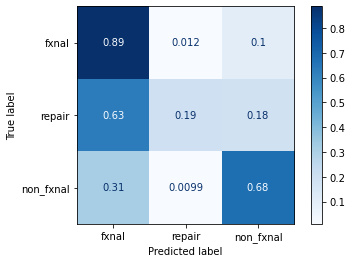

In [51]:
ConfusionMatrixDisplay.from_estimator(pipe1,
                                      X_train,
                                      y_train,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

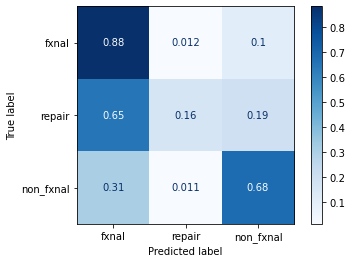

In [52]:
ConfusionMatrixDisplay.from_estimator(pipe1,
                                      X_test,
                                      y_test,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

> Poor performance on the "repair" class
>
> Maybe use techniques for imbalanced data

#### 4.1.2. KNNImputer (Same Performance as SimpleImputer)

In [53]:
ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

knn_imputer = KNNImputer(n_neighbors=15)

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe2 = Pipeline([("ohe", mct), ("impu", knn_imputer), ("sc", ss), ("clf", logreg)])

pipe2.fit(X_train, y_train)
pipe2.score(X_train, y_train).round(3), pipe2.score(X_test, y_test).round(3)

(0.756, 0.753)

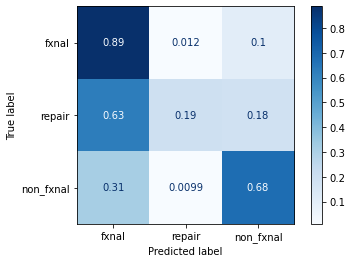

In [54]:
ConfusionMatrixDisplay.from_estimator(pipe2,
                                      X_train,
                                      y_train,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

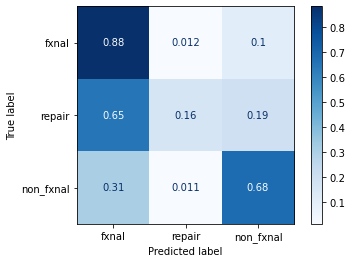

In [55]:
ConfusionMatrixDisplay.from_estimator(pipe2,
                                      X_test,
                                      y_test,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

#### 4.1.3. Include 9 Numeric Features (No Difference)

In [56]:
num_feats = list(X.select_dtypes(include = "number").drop(columns = ["id"]).columns)
#list of numeric features

In [57]:
X_num_cat = X[num_feats + cat_feats]

In [58]:
X_num_cat.shape

(59400, 22)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, random_state=42, stratify=y)

In [60]:
ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe3 = Pipeline([("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe3.fit(X_train, y_train)
pipe3.score(X_train, y_train).round(3), pipe3.score(X_test, y_test).round(3)

(0.756, 0.753)

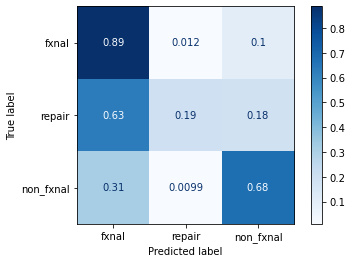

In [61]:
ConfusionMatrixDisplay.from_estimator(pipe3,
                                      X_train,
                                      y_train,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

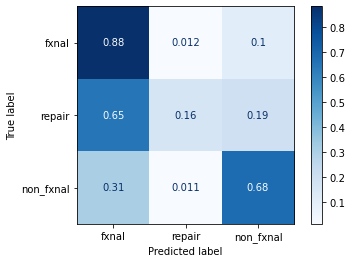

In [62]:
ConfusionMatrixDisplay.from_estimator(pipe3,
                                      X_test,
                                      y_test,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

> The 9 numeric features are not useful for prediction

In [77]:
# X["lga"].str.lower().str.contains("zanzibar").sum()
# X["ward"].str.lower().str.contains("zanzibar").sum()
# X["region"].str.lower().str.contains("zanzibar").sum()
# X["basin"].str.lower().str.contains("zanzibar").sum()
# X["subvillage"].str.lower().str.contains("zanzibar").sum()
# zanzibar = X["subvillage"].str.lower().str.contains("zanzibar")

X[zanzibar == True]["subvillage"]

## 5. Modeling with Imbalanced Data

In [430]:
cat_feats = ["region",
             "lga",
             "public_meeting",
             "scheme_management",
             "permit",
             "extraction_type",
             "management",
             "payment_type",
             "water_quality",
             "quantity_group",
             "source",
             "waterpoint_type"]

In [431]:
X_cat = X[cat_feats]
X_cat.isna().sum()

region                  0
lga                     0
public_meeting       3334
scheme_management    3877
permit               3056
extraction_type         0
management              0
payment_type            0
water_quality           0
quantity_group          0
source                  0
waterpoint_type         0
dtype: int64

In [432]:
X_cat.shape

(59400, 12)

In [433]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, random_state=42, stratify=y)

### 5.1. Model without Dealing with Imbalanced Data (Repeat for Reference)

In [465]:
#without dealing with imbalance
ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe4 = Pipeline([("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe4.fit(X_train, y_train)
pipe4.score(X_train, y_train).round(3), pipe4.score(X_test, y_test).round(3)

(0.748, 0.748)

In [466]:
balanced_accuracy_score(y_test, pipe4.predict(X_test)).round(3)

0.559

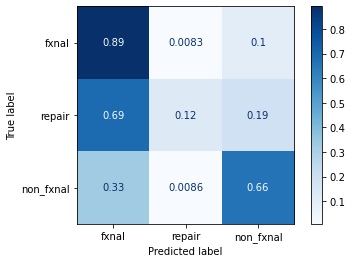

In [530]:
ConfusionMatrixDisplay.from_estimator(pipe4,
                                      X_test,
                                      y_test,
                                      cmap="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize = "true");

In [442]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline

### 5.2. Oversampling to Fully Balanced Data

In [450]:
#Over sampling to make all classes have the same population. This is extreme.
ros = RandomOverSampler(random_state=42,
                        sampling_strategy="not majority")

ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe5 = ImbPipeline([ ("ros", ros), ("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

# gs5 = GridSearchCV(pipe5,
#                    {"ros__sampling_strategy": [0.25, 0.5, 0.75, 1.0]},
#                    scoring="balanced_accuracy", 
#                    n_jobs=-1)
# gs5.fit(X_train, y_train)

pipe5.fit(X_train, y_train)

Pipeline(steps=[('ros',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='not majority')),
                ('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['region', 'lga',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit', 'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_quality',
              

In [461]:
pipe5.score(X_train, y_train).round(3), pipe5.score(X_test, y_test).round(3)

(0.651, 0.652)

In [462]:
balanced_accuracy_score(y_test, pipe5.predict(X_test)).round(3)

0.665

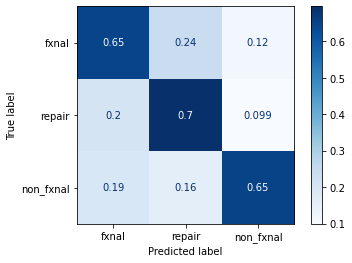

In [454]:
ConfusionMatrixDisplay.from_estimator(pipe5,
                                      X_test,
                                      y_test,
                                      cmap="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize = "true");

In [456]:
y_train.value_counts()

functional                 24194
non functional             17118
functional needs repair     3238
Name: status_group, dtype: int64

### 5.3. Oversample the Least Populated Class to 10,000 Observations 

In [457]:
#resample the least populated class (funtional needs repair) to 10_000 observations (up from 3_238)
ros = RandomOverSampler(random_state=42,
                        sampling_strategy={"functional needs repair": 10_000})

ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe6 = ImbPipeline([ ("ros", ros), ("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe6.fit(X_train, y_train)

Pipeline(steps=[('ros',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy={'functional needs repair': 10000})),
                ('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['region', 'lga',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit', 'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_qual

In [463]:
pipe6.score(X_train, y_train).round(3), pipe6.score(X_test, y_test).round(3)

(0.723, 0.723)

In [464]:
balanced_accuracy_score(y_test, pipe6.predict(X_test)).round(3)

0.631

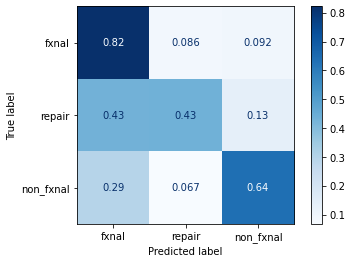

In [469]:
ConfusionMatrixDisplay.from_estimator(pipe6,
                                      X_test,
                                      y_test,
                                      cmap="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize = "true");

### 5.4. Oversample the Least Populated Class to 15,000 Observations 

In [470]:
#resample the least populated class (funtional needs repair) to 15_000 observations (up from 3_238)
ros = RandomOverSampler(random_state=42,
                        sampling_strategy={"functional needs repair": 15_000})

ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe7 = ImbPipeline([ ("ros", ros), ("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe7.fit(X_train, y_train)

Pipeline(steps=[('ros',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy={'functional needs repair': 15000})),
                ('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['region', 'lga',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit', 'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_qual

In [471]:
pipe7.score(X_train, y_train).round(3), pipe7.score(X_test, y_test).round(3)

(0.693, 0.697)

In [472]:
balanced_accuracy_score(y_test, pipe7.predict(X_test)).round(3)

0.658

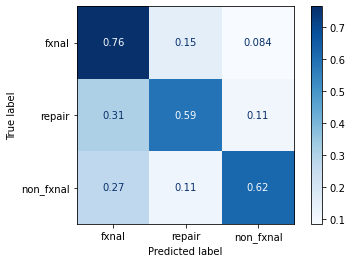

In [474]:
ConfusionMatrixDisplay.from_estimator(pipe7,
                                      X_test,
                                      y_test,
                                      cmap="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize = "true");

### 5.4. Oversample the Least Populated Class to 20,000 Observations 

In [475]:
#resample the least populated class (funtional needs repair) to 20_000 observations (up from 3_238)
ros = RandomOverSampler(random_state=42,
                        sampling_strategy={"functional needs repair": 20_000})

ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe8 = ImbPipeline([ ("ros", ros), ("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe8.fit(X_train, y_train)

Pipeline(steps=[('ros',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy={'functional needs repair': 20000})),
                ('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['region', 'lga',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit', 'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_qual

In [476]:
pipe8.score(X_train, y_train).round(3), pipe8.score(X_test, y_test).round(3)

(0.664, 0.667)

In [477]:
balanced_accuracy_score(y_test, pipe8.predict(X_test)).round(3)

0.663

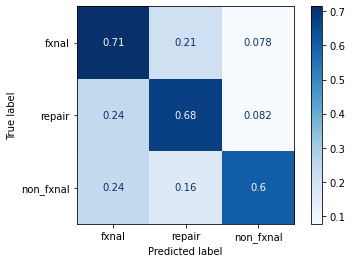

In [478]:
ConfusionMatrixDisplay.from_estimator(pipe8,
                                      X_test,
                                      y_test,
                                      cmap="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize = "true");

## 6. Tanzania Census Data 2012

In [80]:
tanz = pd.read_csv("Tanzania_2012_en.csv")

In [81]:
tanz.info()
tanz.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60794 entries, 0 to 60793
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Indicator    60794 non-null  object 
 1   Unit         60794 non-null  object 
 2   Subgroup     60794 non-null  object 
 3   Area         60794 non-null  object 
 4   Area ID      60794 non-null  object 
 5   Time Period  60794 non-null  object 
 6   Source       60794 non-null  object 
 7   Data Value   60781 non-null  float64
 8   Footnotes    56979 non-null  object 
dtypes: float64(1), object(8)
memory usage: 4.2+ MB


,Indicator,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
0,Children under-5 years severely underweight,Percent,Total,Tanzania,TZA,2015-2016,NBS_ TDHS (2015-2016)_2016,2.7,NaN
1,Production of cement,Tonne,Total,Mainland,TZA001,2009,MoFEA_Economic Survey (ES)_Yearly,34793.0,NaN
2,Production of cement,Tonne,Total,Mainland,TZA001,2010,MoFEA_Economic Survey (ES)_Yearly,2313.0,NaN
3,Production of cement,Tonne,Total,Mainland,TZA001,2011,MoFEA_Economic Survey (ES)_Yearly,2409.0,NaN
4,Production of cement,Tonne,Total,Mainland,TZA001,2012,MoFEA_Economic Survey (ES)_Yearly,2581.0,NaN


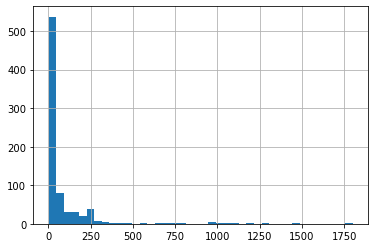

In [98]:
tanz["Indicator"].value_counts().hist(bins = 40);  #773 indicators

In [387]:
tanz["Indicator"].value_counts()[lambda x : x.values > 250]
#149 indicators with more than 100 values
#36 indicators with more than 250 values

Population size                                                  1801
Source of improved drinking water by households                  1472
Improved toilet facilities by household                          1465
Primary school net enrolment ratio                               1299
Source of non improved drinking water by households              1288
Primary school gross enrolment ratio                             1191
Households by type of refuse disposal                            1112
Non improved toilet facilities by household                      1062
Operators engage in crops                                        1021
Planted area in a crops                                           990
Quantity harvested in crops                                       990
Quantity sold in a crops                                          990
Yield in a crops                                                  990
Area harvested in crops                                           990
Pupils who sat for t

> Let's take a look at the top indicators that contain "water" 

### 6.1. Indicators with the Word "water"

In [322]:
tanz["Indicator"].value_counts()[lambda x : x.index.str.lower().str.contains("water")].head(10)
#29 indicators with "water"

Source of improved drinking water by households                                                1472
Source of non improved drinking water by households                                            1288
Water coverage                                                                                  218
Non-revenue water (NRW) for regional centres                                                    130
Population with access to piped or protected water as their main source in regional centres     128
Households within 1 km of drinking water in dry seasons                                          63
Population served with water                                                                     62
Households within 15 minutes to water supply in dry seasons                                      27
Population using an improved drinking water source                                               20
Water demand                                                                                     20


#### 6.1.1. Source of Improved Drinking Water by Households

> Source of improved drinking water by households for each area, divided into 8 subgroups
>
> Each subgroup is a source of improved drinking water
>
> Only for the year 2012
>
> For each Area ID, the Data Value for the subgroup "Improved" is the sum of all other subgroup 

In [634]:
improved_water = tanz["Indicator"] == "Source of improved drinking water by households"
cols_to_drop = ["Indicator", "Unit", "Footnotes", "Source", "Time Period"]
improved_water_df = tanz[improved_water].drop(columns = cols_to_drop)
#Time Period = 2012
#Unit = Percent
#Source = NBS_Population and Housing Census, 2012_2013-2018
improved_water_df

,Subgroup,Area,Area ID,Data Value
16041,Piped Water into dwelling,Kagera,TZA001018,2.9
16042,Piped Water into dwelling,Tarime,TZA001020001,1.5
16512,Piped Water into dwelling,Mtwara,TZA001009,8.1
16513,Piped Water into dwelling,Kahama Township Authority,TZA001017005,17.5
16514,Piped Water into dwelling,Lushoto,TZA001004001,5.2
...,...,...,...,...
19164,Improved,Lindi Urban,TZA001008006,58.5
19165,Improved,Babati,TZA001021001,58.5
19166,Improved,Hanang,TZA001021002,55.4
19167,Improved,Kiteto,TZA001021005,24.7


In [312]:
improved_water_df["Subgroup"].value_counts()
#8 subgroups, equal sizes
#actually 7 subgroups,
#the "Improved" is the sum of all 7 subgroups for each Area ID

Piped Water into dwelling    184
Piped Water to yard/plot     184
Tube well/ borehole          184
Protected dug well           184
Rain water collection        184
Public tap/ standpipe        184
Protected Spring             184
Improved                     184
Name: Subgroup, dtype: int64

In [645]:
improved_water_df[subgr_improved]["Area ID"].str.len().value_counts()
#Area ID length of 9 is for regions (total 30 of them)
#25 regions with data availabel are mainland only, no data for 5 regions of Zanzibar island,
#Area ID length of 12 is for sub-regions
#we focus on regions

12    159
9      25
Name: Area ID, dtype: int64

In [646]:
#focus on the subgroup "Improved"
subgr_improved = improved_water_df["Subgroup"]=="Improved"
#and regions
regions = improved_water_df[subgr_improved]["Area ID"].str.len()==9

improved_by_region = improved_water_df[subgr_improved & regions].drop(columns = "Subgroup")
improved_by_region = improved_by_region.sort_values(by="Data Value")
improved_by_region

,Area,Area ID,Data Value
19097,Tabora,TZA001014,27.3
19054,Mara,TZA001020,32.9
19150,Geita,TZA001025,33.7
19021,Lindi,TZA001008,35.0
19096,Singida,TZA001013,38.5
18988,Kagera,TZA001018,39.0
19095,Rukwa,TZA001015,41.8
19099,Shinyanga,TZA001017,43.2
18999,Katavi,TZA001023,44.3
19100,Tanga,TZA001004,48.0


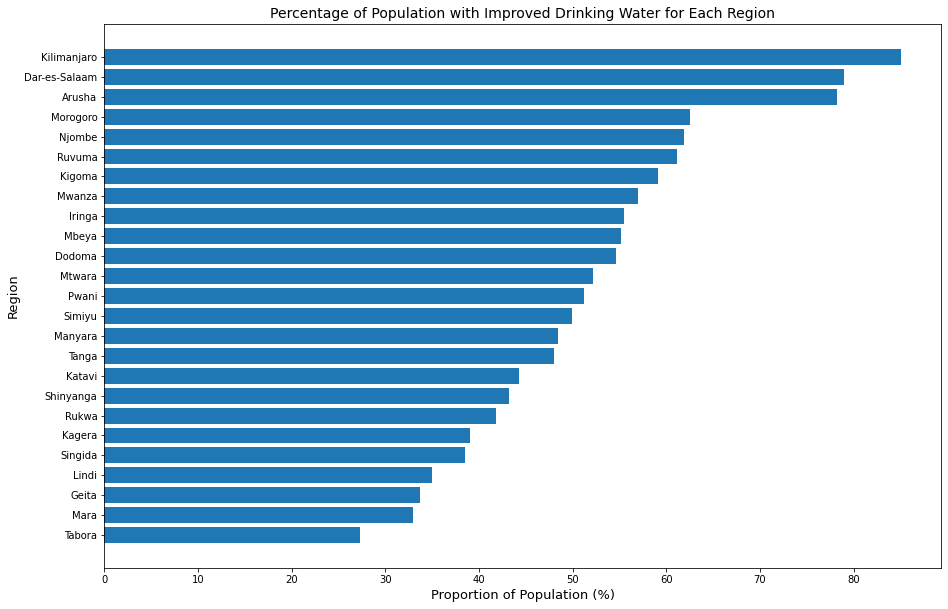

In [667]:
plt.figure(figsize=(15,10))
plt.barh(y = improved_by_region["Area"],
         width = improved_by_region["Data Value"])
plt.title("Percentage of Population with Improved Drinking Water for Each Region", fontsize=14)
plt.xlabel("Proportion of Population (%)", fontsize=13)
plt.ylabel("Region", fontsize=13);

> Overall, less than half of the population have access to improved drinking water
>
> In worst regions, only a third have access to improved drinking water

#### 6.1.2. Source of Non Improved Drinking Water by Households

> Source of non improved drinking water by households for each area, divided into 7 subgroups
>
> Each subgroup is a source of non improved drinking water
>
> Only for the year 2012
>
> For each Area ID, the Data Value for the subgroup "Non-improved" is the sum of all other subgroup

In [303]:
non_improved_water = tanz["Indicator"] == "Source of non improved drinking water by households"
cols_to_drop = ["Indicator", "Unit", "Time Period", "Source", "Footnotes"]
non_improved_water_df = tanz[non_improved_water].drop(columns = cols_to_drop)
#Time Period = 2012
#Unit = Percent
#Source = NBS_Population and Housing Census, 2012_2013-2018
non_improved_water_df

,Subgroup,Area,Area ID,Data Value
16589,Non-Improved,Mbulu,TZA001021003,56.2
16590,Non-Improved,Simanjiro,TZA001021004,54.8
16591,Non-Improved,Rorya,TZA001020006,89.2
16592,Non-Improved,Butiam,TZA001020007,73.7
16593,Non-Improved,Kilosa,TZA001005001,40.4
...,...,...,...,...
19265,Surface water (river dam lake etc.),Shinyanga Urban,TZA001017001,5.9
19266,Surface water (river dam lake etc.),Kishapu,TZA001017002,56.9
19267,Surface water (river dam lake etc.),Shinyanga R,TZA001017003,25.1
19268,Surface water (river dam lake etc.),Kahama,TZA001017004,7.1


In [304]:
non_improved_water_df["Subgroup"].value_counts()
#7 subgroups, equal sizes
#the Non-Improved subgroup is the sum of other 6 subrgoups

Non-Improved                           184
Unprotected dug well                   184
Unprotected Spring                     184
Bottled water                          184
Cart with small tank/drum              184
Tanker truck                           184
Surface water (river dam lake etc.)    184
Name: Subgroup, dtype: int64

In [648]:
non_improved_water_df["Area ID"].str.len().value_counts()

12    1113
9      175
Name: Area ID, dtype: int64

In [650]:
#focus on the "non-improved" subgroup and regions (Area ID with len = 9)
non_improved = non_improved_water_df["Subgroup"]=="Non-Improved"
regions = non_improved_water_df["Area ID"].str.len()==9
non_improved_by_region = non_improved_water_df[non_improved & regions].drop(columns = "Subgroup").sort_values(by="Data Value")
non_improved_by_region

,Area,Area ID,Data Value
17819,Kilimanjaro,TZA001003,15.0
17643,Dar-es-Salaam,TZA001007,21.1
17632,Arusha,TZA001002,21.8
17580,Morogoro,TZA001005,37.5
17608,Njombe,TZA001022,38.1
17609,Ruvuma,TZA001010,38.9
17676,Kigoma,TZA001016,41.2
17607,Mwanza,TZA001019,43.0
17654,Iringa,TZA001011,44.5
17558,Mbeya,TZA001012,44.8


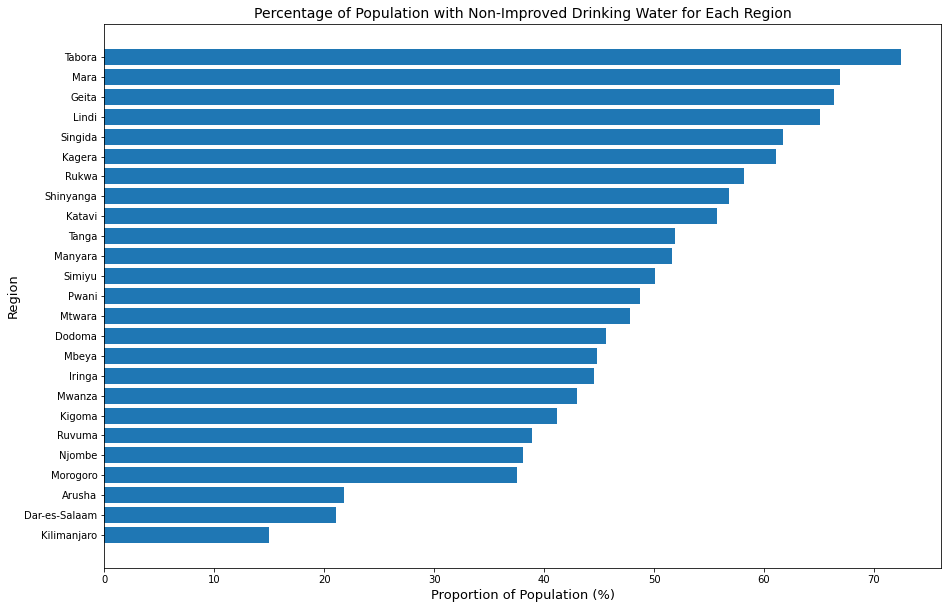

In [668]:
plt.figure(figsize=(15,10))
plt.barh(y = non_improved_by_region["Area"],
         width = non_improved_by_region["Data Value"])
# plt.vlines(x=34.4, ymin=-1, ymax=30, colors="orange", linestyles="--")
plt.title("Percentage of Population with Non-Improved Drinking Water for Each Region", fontsize=14)
plt.xlabel("Proportion of Population (%)", fontsize=13)
plt.ylabel("Region", fontsize=13);
#the Data Value in percent most likely means percentage of population

> This indicator complements the previous one (improved drinking water). They add up to 100% for each region.

#### 6.1.3. Water Coverage

> Water coverage each year between 2008 and 2012 for 24 regions 
> 
> The data for each year is duplicated
>
> Most areas have 5 data points, 1 for each year
>
> What does water coverage mean in this case?

In [394]:
water_coverage_df = tanz[tanz["Indicator"] == "Water coverage"]
#Subgroup =  Rural
#Unit = percent
water_coverage_df = water_coverage_df.drop(columns = ["Indicator", "Unit", "Subgroup", "Footnotes"])
water_coverage_df.sort_values(by = "Area")

,Area,Area ID,Time Period,Source,Data Value
972,Arusha,TZA001002,2009,EWURA_Water Utilities Performance Review_Yearly,66.720000
1014,Arusha,TZA001002,2009,MoWI_Rural Water Supply Database_Yearly,66.720000
973,Arusha,TZA001002,2010,EWURA_Water Utilities Performance Review_Yearly,60.840000
993,Arusha,TZA001002,2008,MoWI_Rural Water Supply Database_Yearly,59.600000
1055,Arusha,TZA001002,2008,EWURA_Water Utilities Performance Review_Yearly,59.600000
...,...,...,...,...,...
1046,Tanga,TZA001004,2009,EWURA_Water Utilities Performance Review_Yearly,68.900000
1047,Tanga,TZA001004,2010,EWURA_Water Utilities Performance Review_Yearly,65.710000
1073,Tanga,TZA001004,2011,MoWI_Rural Water Supply Database_Yearly,58.230000
1048,Tanga,TZA001004,2011,EWURA_Water Utilities Performance Review_Yearly,58.230000


In [395]:
water_coverage_df["Area"].value_counts()

Ruvuma           10
Kilimanjaro      10
Dodoma           10
Kigoma           10
Iringa           10
Dar-es-Salaam    10
Arusha           10
Shinyanga        10
Tabora           10
Singida          10
Rukwa            10
Tanga            10
Kagera           10
Mwanza           10
Pwani            10
Mtwara           10
Morogoro         10
Mara             10
Mbeya            10
Manyara          10
Lindi            10
Njombe            4
Geita             2
Katavi            2
Name: Area, dtype: int64

In [404]:
water_coverage_df["Time Period"].value_counts()

2012    48
2010    44
2008    42
2009    42
2011    42
Name: Time Period, dtype: int64

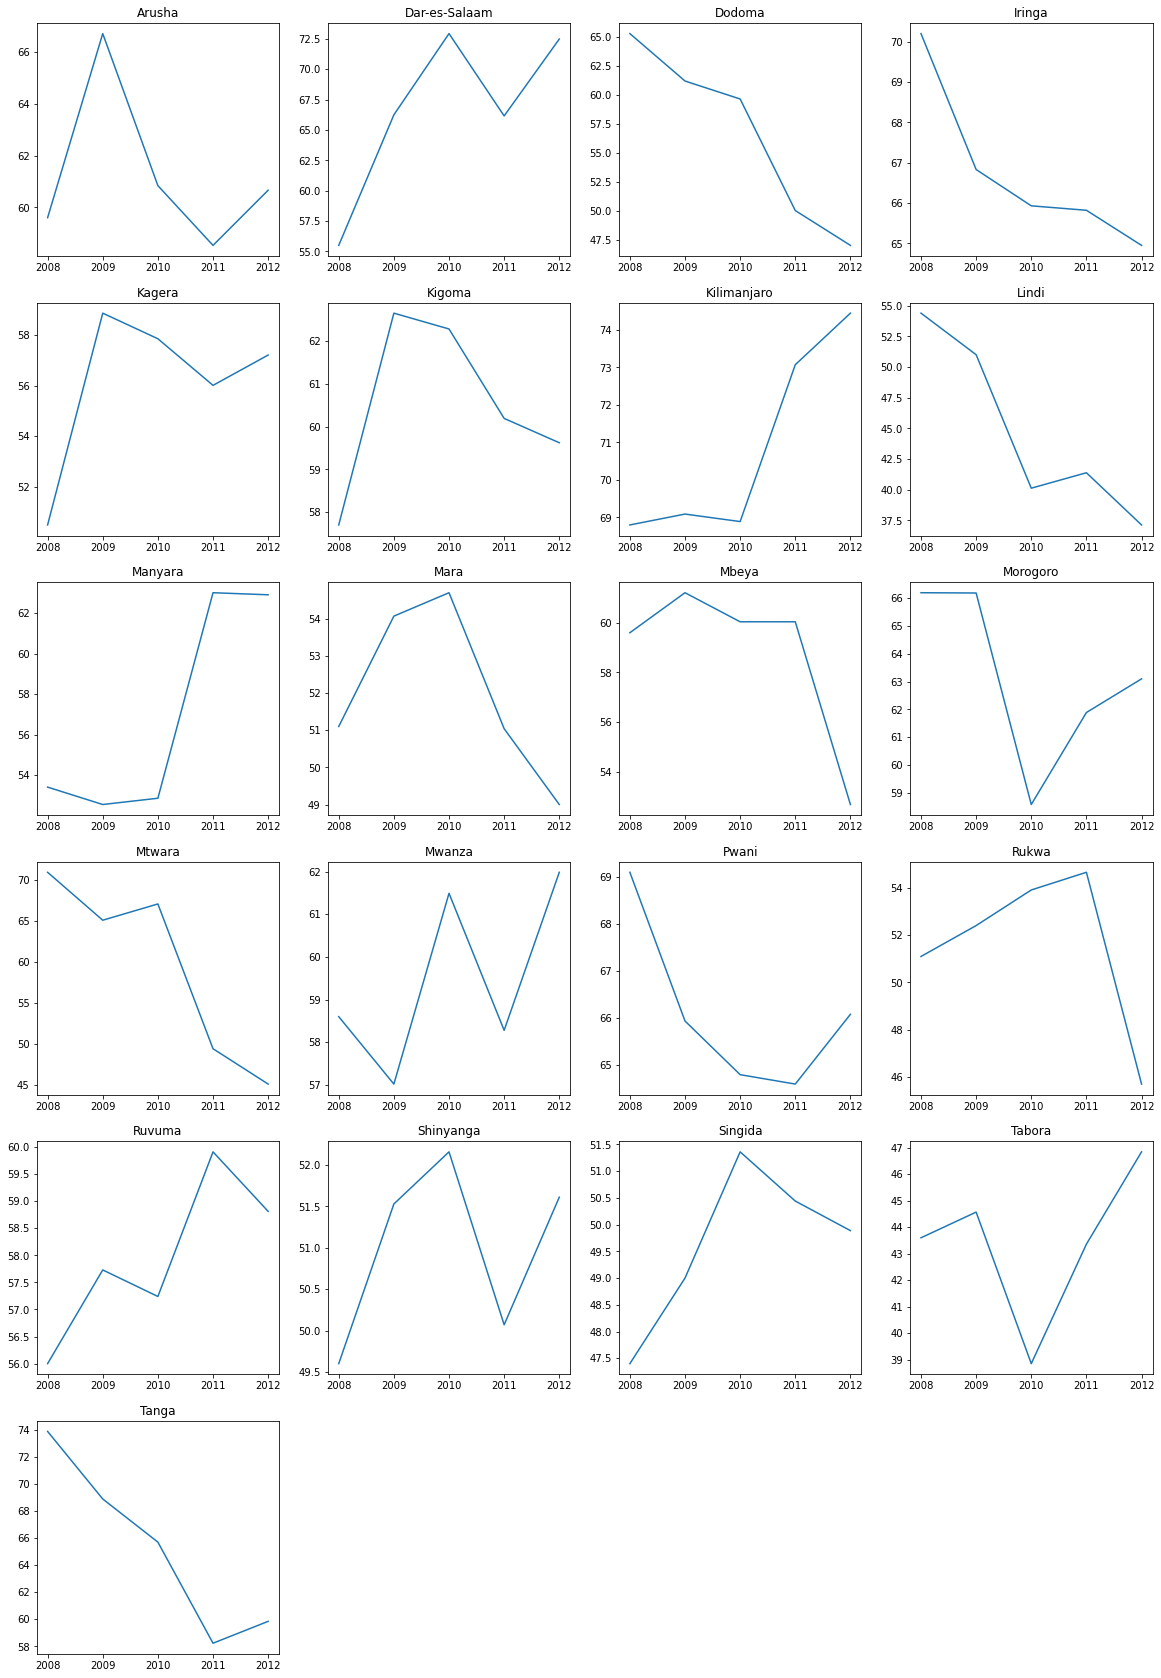

In [407]:
#plot water coverage vs. year for 21 areas
#these plots might not be that useful, remove them if don't use

fig = plt.figure(figsize=(20,30))

#exclude Geita, Katavi, Njombe. They have only 1 or 2 data points
#21 areas left
areas = np.array(water_coverage_df["Area"].value_counts().index[:-3])
areas.sort()

for idx, area in enumerate(areas):
    plt.subplot(6,4,idx+1)
    area_df = water_coverage_df[water_coverage_df["Area"]==area]
    area_df.sort_values(by = "Time Period", inplace=True)
    plt.plot(area_df["Time Period"], area_df["Data Value"])
    plt.title(area)

#### 6.1.4. Non-revenue Water (NRW) for Regional Centres

> Yearly NRW for each area over 5 years between 2010 and 2015
>
> Non-revenue water: water that has beeen produced and is "lost" before it reaches customers (leak, theft)

In [674]:
nrw = tanz["Indicator"]=="Non-revenue water (NRW) for regional centres"
cols_to_drop = ["Indicator", "Unit", "Subgroup", "Source", "Footnotes"]
#Unit = Percent
#Subgroup = Total
#Source = EWURA_Water Utilities Performance Review_Yearly
#27 areas
#5 Time Period: 2010-11, 11-12, 12-13, 13-14, 14-15
nrw_df = tanz[nrw].drop(columns = cols_to_drop)
nrw_df.sort_values(by = "Area")

,Area,Area ID,Time Period,Data Value
55521,Arusha,TZA001002,2010-2011,40.6
55522,Arusha,TZA001002,2011-2012,37.4
55523,Arusha,TZA001002,2012-2013,40.6
55524,Arusha,TZA001002,2013-2014,42.8
55525,Arusha,TZA001002,2014-2015,44.9
...,...,...,...,...
55506,Tanga,TZA001004,2010-2011,26.3
55507,Tanga,TZA001004,2011-2012,27.8
55508,Tanga,TZA001004,2012-2013,25.9
55509,Tanga,TZA001004,2013-2014,22.6


In [672]:
nrw_df["Time Period"].value_counts()

2012-2013    27
2011-2012    26
2013-2014    26
2014-2015    26
2010-2011    25
Name: Time Period, dtype: int64

In [681]:
#focus on newest data: Time Period = "2014-2015"
#and regions: Area ID with length = 9
#23 regions
y2014 = nrw_df["Time Period"]=="2014-2015"
regions = nrw_df["Area ID"].str.len()==9
nrw_2014_by_region = nrw_df[y2014 & regions].drop(columns=["Time Period", "Area ID"])
nrw_2014_by_region = nrw_2014_by_region.sort_values(by = "Data Value")
nrw_2014_by_region

,Area,Data Value
55510,Tanga,22.6
55505,Shinyanga,22.6
55540,Geita,23.0
55609,Kilimanjaro,24.1
55480,Ruvuma,26.9
55398,Mtwara,28.8
55520,Dodoma,29.7
55545,Kigoma,30.0
55457,Manyara,31.8
55485,Rukwa,32.7


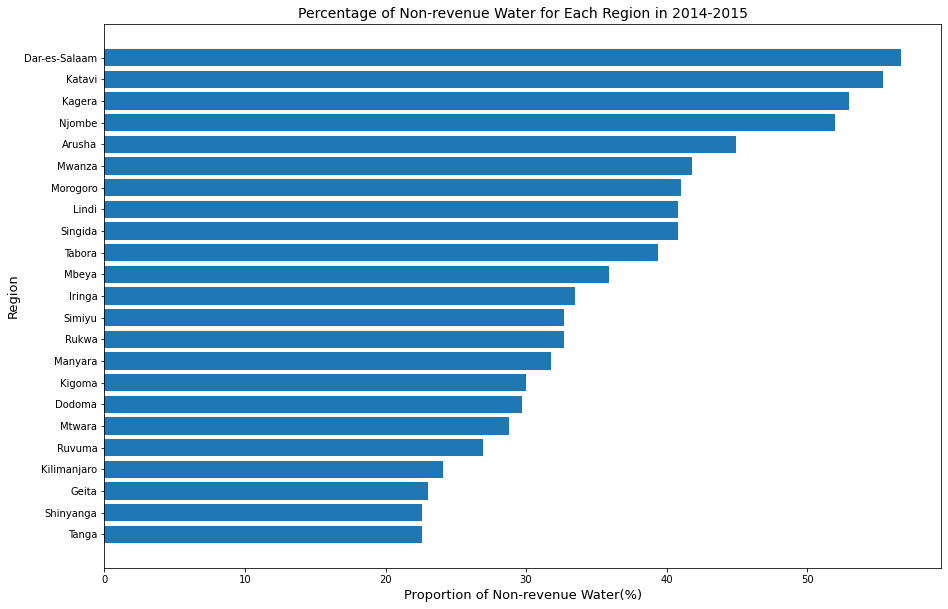

In [693]:
plt.figure(figsize=(15,10))
plt.barh(y = nrw_2014_by_region["Area"],
         width = nrw_2014_by_region["Data Value"])
plt.title("Percentage of Non-revenue Water for Each Region in 2014-2015", fontsize=14)
plt.xlabel("Proportion of Non-revenue Water(%)", fontsize=13)
plt.ylabel("Region", fontsize=13);

> Having high level of non-revenue water is a problem: a lot of water has been wasted or stolen !!!

#### 6.1.5. Population with Access to Piped or Protected Water as Their Main Source in Regional Centres

> Yearly percentage of population with access to piped/protected water for each area over 5 years between 2010 and 2015
>
> This might be an useful indicator

In [235]:
access_to_water = tanz["Indicator"]=="Population with access to piped or protected water as their main source in regional centres"
cols_to_drop = ["Indicator", "Unit", "Subgroup", "Source", "Footnotes"]
#Unit = Percent
#Subgroup = Total
#Source = EWURA_Water Utilities Performance Review_Yearly
#26 areas
#5 Time Period: 2010-11, 11-12, 12-13, 13-14, 14-15
access_to_water_df = tanz[access_to_water].drop(columns = cols_to_drop)
access_to_water_df
access_to_water_df.sort_values(by = "Area")

,Area,Area ID,Time Period,Data Value
55575,Arusha,TZA001002,2010-2011,97.5
55579,Arusha,TZA001002,2014-2015,82.0
55578,Arusha,TZA001002,2013-2014,82.0
55577,Arusha,TZA001002,2012-2013,78.0
55576,Arusha,TZA001002,2011-2012,70.4
...,...,...,...,...
55560,Tanga,TZA001004,2010-2011,92.0
55561,Tanga,TZA001004,2011-2012,98.4
55564,Tanga,TZA001004,2014-2015,97.0
55562,Tanga,TZA001004,2012-2013,99.0


In [690]:
#focus on most recent Time Period: 2014-2015
#and regions: Area ID length = 9
#23 regions
y2014 = access_to_water_df["Time Period"]=="2014-2015"
regions = access_to_water_df["Area ID"].str.len()==9

access_to_water_2014_by_region = access_to_water_df[y2014 & regions].drop(columns=["Time Period", "Area ID"])
access_to_water_2014_by_region = access_to_water_2014_by_region.sort_values(by="Data Value")
access_to_water_2014_by_region

,Area,Data Value
55441,Njombe,30.0
55554,Simiyu,47.0
55594,Geita,59.0
55559,Shinyanga,61.0
55584,Dar-es-Salaam,62.0
55635,Rukwa,62.0
55408,Lindi,63.0
55640,Singida,65.0
55626,Katavi,68.0
55599,Kigoma,69.0


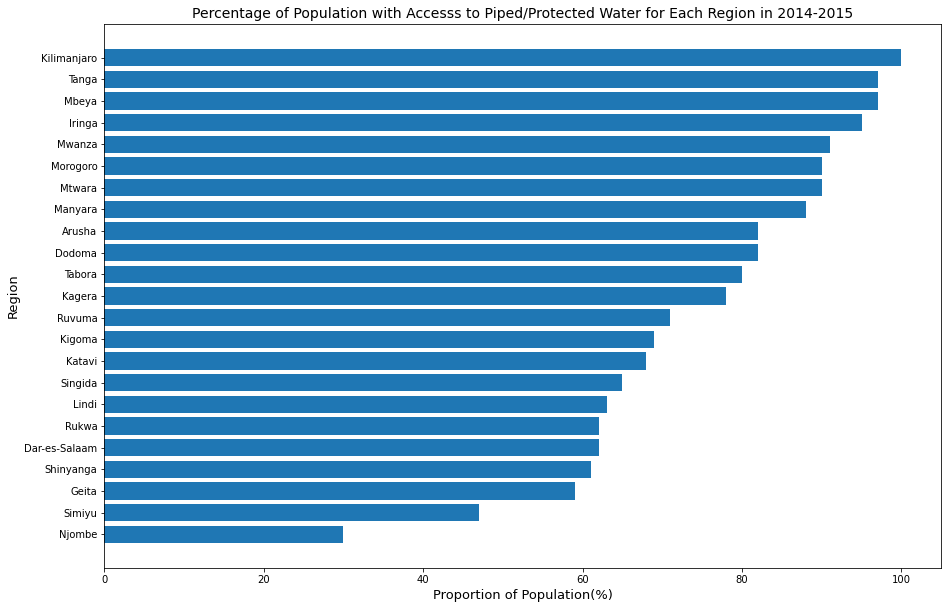

In [692]:
plt.figure(figsize=(15,10))
plt.barh(y = access_to_water_2014_by_region["Area"],
         width = access_to_water_2014_by_region["Data Value"])
plt.title("Percentage of Population with Accesss to Piped/Protected Water for Each Region in 2014-2015", fontsize=14)
plt.xlabel("Proportion of Population(%)", fontsize=13)
plt.ylabel("Region", fontsize=13);

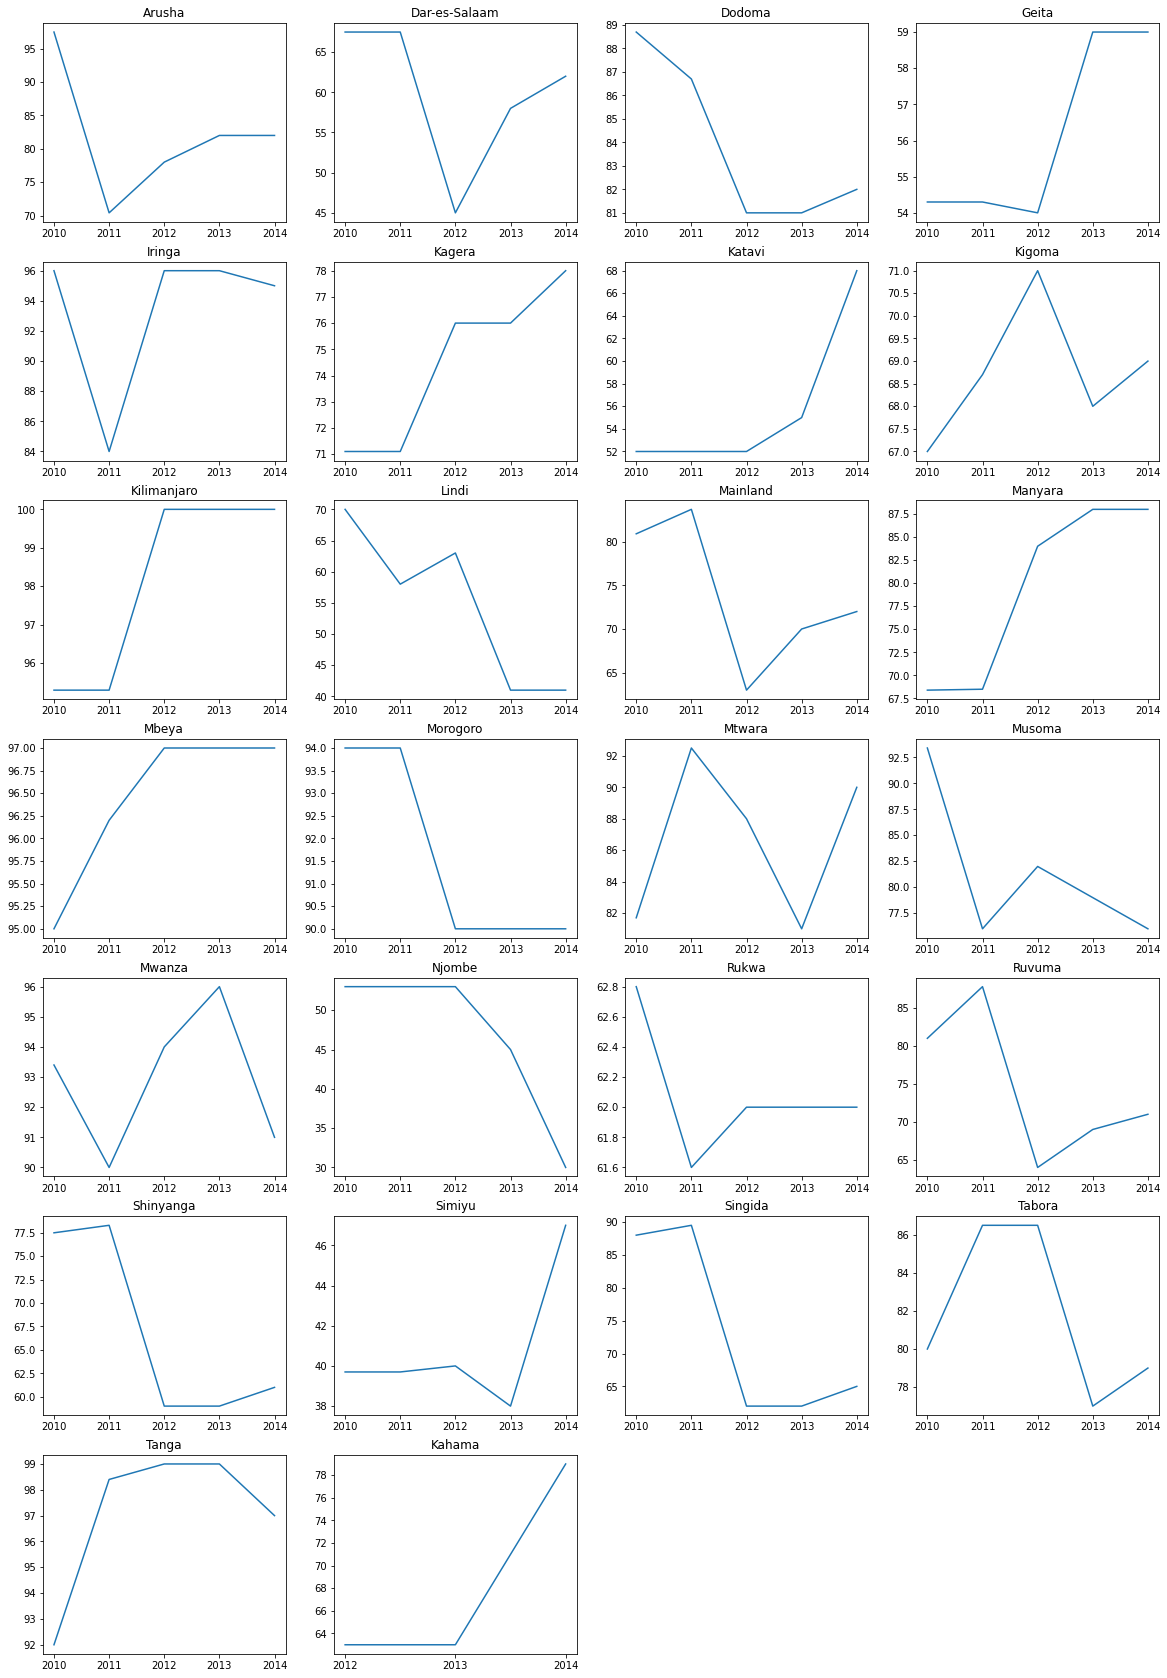

In [275]:
#plot for each region over time
#might not be that useful, remove if don't use

fig = plt.figure(figsize=(20,30))

areas = np.array(access_to_water_df["Area"].value_counts().index[:25]) #no Kahama which has data for 3 years only
areas.sort() #sort A to Z
years = [2010, 2011, 2012, 2013, 2014]

#plot all areas except for Kahama
for idx, area in enumerate(areas):
    plt.subplot(7,4,idx+1)
    pop_pct = access_to_water_df[access_to_water_df["Area"]==area]["Data Value"]
    plt.plot(years, pop_pct)
    plt.title(area)

#plot Kahama
plt.subplot(7,4,26)
pop_pct_kahama = access_to_water_df[access_to_water_df["Area"]=="Kahama"]["Data Value"]
plt.plot(years[2:], pop_pct_kahama)
plt.title("Kahama")
plt.xticks(ticks = years[2:], labels = ["2012", "2013", "2014"]);

### 6.2. Indicators Related to Health

In [320]:
tanz["Indicator"].value_counts()[lambda x : x.index.str.lower().str.contains("diarrhoea")]

Children under-5 years with diarrhoea                                        220
Children under-5 years who drink more fluids during diarrhoea                 83
Children under-5 years who receive any ORT for diarrhoea                      60
Children under-5 years with diarrhoea taken to a health facility/provider     52
Children under-5 years who given ORS and zinc during diarrhoea                18
Name: Indicator, dtype: int64

> ORT = Oral Rehydration Therapy
>
> ORS = Oral Rehydration Solution

#### 6.2.1. Children Under-5 Years with Diarrhoea

In [345]:
u5_diarrhoea = tanz["Indicator"] == "Children under-5 years with diarrhoea"
cols_to_drop = ["Indicator", "Unit", "Source", "Footnotes"]
u5_diarrhoea_df = tanz[u5_diarrhoea].drop(columns = cols_to_drop)
#Unit = Percent
u5_diarrhoea_df

,Subgroup,Area,Area ID,Time Period,Data Value
4298,Female,Tanzania,TZA,2004-2005,11.7
4299,Female,Mainland,TZA001,2004-2005,11.7
4300,Female No education,Mainland,TZA001,2004-2005,13.1
4301,Female Primary complete,Mainland,TZA001,2004-2005,11.9
4302,Female Primary incomplete,Mainland,TZA001,2004-2005,13.9
...,...,...,...,...,...
9951,Total,Dar-es-Salaam,TZA001007,2010,15.5
9952,Total,Lindi,TZA001008,2010,19.2
9953,Total,Mtwara,TZA001009,2010,13.7
9954,Urban,Tanzania,TZA,1999,9.8


In [346]:
u5_diarrhoea_df["Subgroup"].value_counts()
#will focus on the Total subgroup

Total                        160
Rural                         10
Urban                          9
Female                         7
Male                           7
Fourth wealth quintile         4
Highest wealth quintile        4
Lowest wealth quintile         4
Middle wealth quintile         4
Second wealth quintile         4
Female No education            2
Female Primary complete        2
Female Primary incomplete      2
Female Secondary               1
Name: Subgroup, dtype: int64

In [347]:
#focus on the subgroup Total
subgr_total = u5_diarrhoea_df["Subgroup"]=="Total"
u5_diarrhoea_df_total = u5_diarrhoea_df[subgr_total].drop(columns = ["Subgroup"])
u5_diarrhoea_df_total.sort_values(by = "Area").head(12)

,Area,Area ID,Time Period,Data Value
9936,Arusha,TZA001002,2010,12.6
8963,Arusha,TZA001002,1991-1992,23.3
7762,Arusha,TZA001002,2015-2016,9.2
9492,Arusha,TZA001002,1996,14.8
4319,Arusha,TZA001002,2004-2005,10.8
6133,Arusha,TZA001002,2010,12.6
6154,Dar-es-Salaam,TZA001007,2010,15.5
8978,Dar-es-Salaam,TZA001007,1991-1992,12.0
9507,Dar-es-Salaam,TZA001007,1996,10.0
4341,Dar-es-Salaam,TZA001007,2004-2005,7.4


In [660]:
u5_diarrhoea_df["Time Period"].value_counts()
#will focus on the newest time period 2015-2016

2010         74
2004-2005    46
2015-2016    41
1996         27
1991-1992    26
1999          6
Name: Time Period, dtype: int64

In [662]:
u5_diarrhoea_df["Area ID"].str.len().value_counts()
#will focus on regions. There Area ID length is 9

9    143
6     44
3     33
Name: Area ID, dtype: int64

In [665]:
subgr_total = u5_diarrhoea_df["Subgroup"]=="Total"
y2015 = u5_diarrhoea_df["Time Period"]=="2015-2016"
regions = u5_diarrhoea_df["Area ID"].str.len()==9

u5_diarrhoea_by_region_y2015 = u5_diarrhoea_df[subgr_total & y2015 & regions].drop(columns = "Subgroup")
u5_diarrhoea_by_region_y2015 = u5_diarrhoea_by_region_y2015.sort_values(by="Data Value")
u5_diarrhoea_by_region_y2015
#percentage of children under-5 that had diarrhoea in 2015-2016

,Area,Area ID,Time Period,Data Value
7775,Tabora,TZA001014,2015-2016,5.2
7764,Tanga,TZA001004,2015-2016,6.1
7788,Kusini Unguja,TZA002052,2015-2016,7.8
7772,Iringa,TZA001011,2015-2016,8.0
7765,Morogoro,TZA001005,2015-2016,8.5
7786,Geita,TZA001025,2015-2016,8.7
7762,Arusha,TZA001002,2015-2016,9.2
7789,Mjini Magharibi,TZA002053,2015-2016,9.3
7791,Kusini Pemba,TZA002055,2015-2016,9.5
7774,Singida,TZA001013,2015-2016,9.5


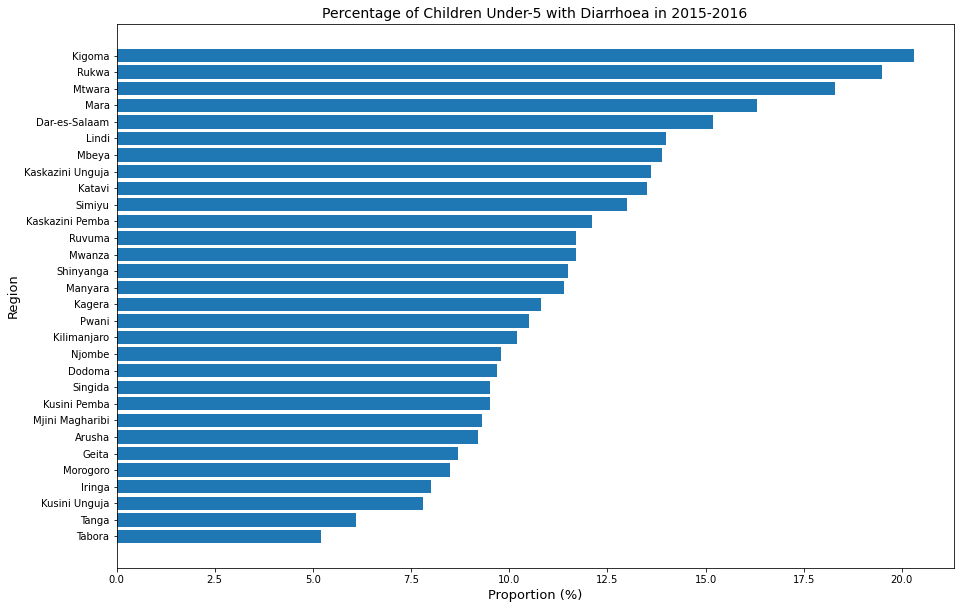

In [666]:
plt.figure(figsize=(15,10))
plt.barh(y = u5_diarrhoea_by_region_y2015["Area"],
         width = u5_diarrhoea_by_region_y2015["Data Value"])
# plt.vlines(x=34.4, ymin=-1, ymax=30, colors="orange", linestyles="--")
plt.title("Percentage of Children Under-5 with Diarrhoea in 2015-2016", fontsize=14)
plt.xlabel("Proportion (%)", fontsize=13)
plt.ylabel("Region", fontsize=13);

#### 6.2.2. Children Under-5 Years Who Drink More Fluids During Diarrhoea

> What does drink more fluids mean? Does it mean they have access to more fluid (clean water)?

In [372]:
u5_more_fluid = tanz["Indicator"] == "Children under-5 years who drink more fluids during diarrhoea"
cols_to_drop = ["Indicator", "Unit", "Source", "Footnotes"]
u5_more_fluid_df = tanz[u5_more_fluid].drop(columns = cols_to_drop)
#Unit = Percent
u5_more_fluid_df

,Subgroup,Area,Area ID,Time Period,Data Value
4288,Female,Tanzania,TZA,2004-2005,35.2
4289,Female,Mainland,TZA001,2004-2005,37.4
4952,Fourth wealth quintile,Mainland,TZA001,2004-2005,40.5
4953,Highest wealth quintile,Mainland,TZA001,2004-2005,52.2
4954,Lowest wealth quintile,Mainland,TZA001,2004-2005,27.5
...,...,...,...,...,...
9991,Male,Tanzania,TZA,1999,34.0
9992,Rural,Tanzania,TZA,1999,32.4
9993,Rural,Mainland,TZA001,1999,32.2
9994,Total,Tanzania,TZA,1999,31.9


In [373]:
u5_more_fluid_df["Subgroup"].value_counts()

Total                      36
Rural                       8
Urban                       8
Female                      6
Male                        6
Fourth wealth quintile      3
Highest wealth quintile     3
Lowest wealth quintile      3
Middle wealth quintile      3
Second wealth quintile      3
No education                1
Primary complete            1
Primary incomplete          1
Secondary+                  1
Name: Subgroup, dtype: int64

In [374]:
#focus on the subgroup Total
subgr_total = u5_more_fluid_df["Subgroup"]=="Total"
u5_more_fluid_df_total = u5_more_fluid_df[subgr_total].drop(columns = ["Subgroup"])
u5_more_fluid_df_total.sort_values(by = "Area")

,Area,Area ID,Time Period,Data Value
9364,Arusha,TZA001002,1996,46.0
9355,Dar-es-Salaam,TZA001007,1996,73.0
9352,Dodoma,TZA001001,1996,58.0
9361,Iringa,TZA001011,1996,67.9
9345,Kagera,TZA001018,1996,57.7
9343,Kigoma,TZA001016,1996,68.3
9348,Kilimanjaro,TZA001003,1996,82.1
9356,Lindi,TZA001008,1996,66.3
9350,Mainland,TZA001,1996,66.9
9995,Mainland,TZA001,1999,31.7


In [375]:
u5_more_fluid_df_total["Area"].value_counts()

Tanzania         6
Mainland         5
Zanzibar         5
Dar-es-Salaam    1
Arusha           1
Singida          1
Mbeya            1
Iringa           1
Ruvuma           1
Shinyanga        1
Mtwara           1
Lindi            1
Morogoro         1
Pwani            1
Dodoma           1
Tanga            1
Kilimanjaro      1
Mara             1
Mwanza           1
Kagera           1
Kigoma           1
Rukwa            1
Tabora           1
Name: Area, dtype: int64

In [376]:
#mostly 1 data point (year = 1999) for each area
#Tanzania: 6 data points corresponding to 6 time periods 1991-92/1996/1999/2004-05/2010/2015-16
#mainland and Zanzibar: 5 data points, 5 time periods 1991-92/1996/1999/2004-05/2015-16

In [377]:
#let's map the Time Period to Year
#1991-1992 call it 1991
#2004-2005 call it 2004
#2015-2016 call it 2015

map_dict = {"1991-1992": 1991,
            "1996": 1996,
            "1999": 1999,
            "2004-2005": 2004,
            "2010": 2010,
            "2015-2016": 2015}
u5_more_fluid_df_total["Year"] = u5_more_fluid_df_total["Time Period"].map(map_dict)

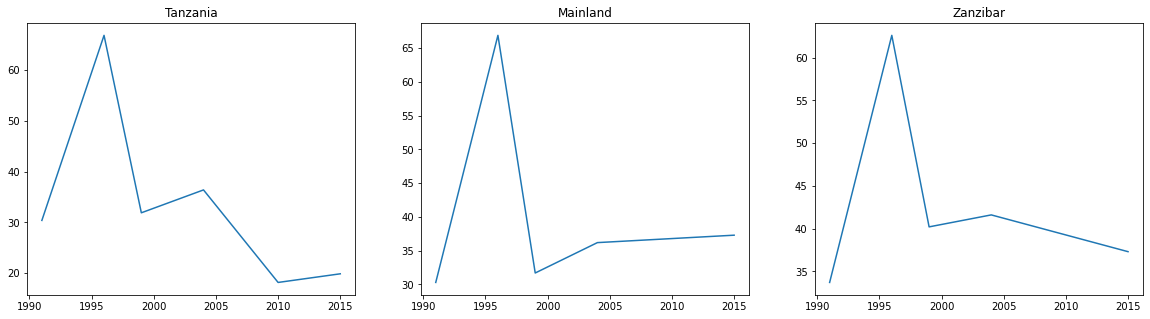

In [379]:
#plot Tanzania as a whole, mainland, and island (Zanzibar)
areas_to_plot = ["Tanzania", "Mainland", "Zanzibar"]

fig = plt.figure(figsize=(20,5))

for idx, area in enumerate(areas_to_plot):
    df = u5_more_fluid_df_total[u5_more_fluid_df_total["Area"] == area]
    df = df.sort_values(by = "Year")
    plt.subplot(1,3,idx+1)    
    plt.plot(df["Year"], df["Data Value"])
    plt.title(area)

> How can Tanzania go down to 20% for 2010 and 2015? They are >35% for Mainland and Zanzibar.

#### 6.2.3. Children under-5 years stunted

In [592]:
u5_stunt = tanz["Indicator"] == "Children under-5 years stunted"
u5_stunt_df = tanz[u5_stunt]
u5_stunt_df.head()

,Indicator,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
4101,Children under-5 years stunted,Percent,Highest wealth quintile,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,15.7,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4102,Children under-5 years stunted,Percent,Lowest wealth quintile,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,44.9,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4103,Children under-5 years stunted,Percent,Male,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,38.6,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4104,Children under-5 years stunted,Percent,Middle wealth quintile,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,40.9,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4105,Children under-5 years stunted,Percent,No education,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,41.2,"TZA_ Demographic & Health Survey, 2004-2005, N..."


In [593]:
u5_stunt_df["Subgroup"].value_counts()

Total                      180
Rural                       18
Urban                       13
Male                         9
Other urban areas            9
Female                       9
No education                 5
Primary complete             5
Primary incomplete           5
Secondary+                   5
Highest wealth quintile      3
Lowest wealth quintile       3
Middle wealth quintile       3
Second wealth quintile       3
Fourth wealth quintile       3
Name: Subgroup, dtype: int64

In [594]:
#focus on subgroup = total
subgr_filter = u5_stunt_df["Subgroup"]=="Total"

In [595]:
u5_stunt_df["Area ID"].str.len().value_counts()

9    150
3     83
6     40
Name: Area ID, dtype: int64

In [596]:
#Area ID length of 9 are for the 30 regions
#focus on those
area_filter = u5_stunt_df["Area ID"].str.len()==9

In [597]:
u5_stunt_total_by_region = u5_stunt_df[subgr_filter & area_filter]
u5_stunt_total_by_region.head()

,Indicator,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
4117,Children under-5 years stunted,Percent,Total,Dodoma,TZA001001,2004-2005,NBS_ TDHS (2004-2005)_2005,44.4,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4118,Children under-5 years stunted,Percent,Total,Arusha,TZA001002,2004-2005,NBS_ TDHS (2004-2005)_2005,27.2,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4119,Children under-5 years stunted,Percent,Total,Kilimanjaro,TZA001003,2004-2005,NBS_ TDHS (2004-2005)_2005,23.4,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4120,Children under-5 years stunted,Percent,Total,Tanga,TZA001004,2004-2005,NBS_ TDHS (2004-2005)_2005,43.3,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4121,Children under-5 years stunted,Percent,Total,Morogoro,TZA001005,2004-2005,NBS_ TDHS (2004-2005)_2005,35.8,"TZA_ Demographic & Health Survey, 2004-2005, N..."


In [598]:
u5_stunt_total_by_region.drop(columns=["Indicator", "Unit", "Subgroup", "Source", "Footnotes"], inplace=True)
u5_stunt_total_by_region.head()

,Area,Area ID,Time Period,Data Value
4117,Dodoma,TZA001001,2004-2005,44.4
4118,Arusha,TZA001002,2004-2005,27.2
4119,Kilimanjaro,TZA001003,2004-2005,23.4
4120,Tanga,TZA001004,2004-2005,43.3
4121,Morogoro,TZA001005,2004-2005,35.8


In [599]:
u5_stunt_total_by_region["Time Period"].value_counts()
#30 means data available for all the regions

2015-2016    30
2014         30
2010         26
2004-2005    21
1991-1992    20
1996         20
2010-2011     1
2012-2013     1
2008-2009     1
Name: Time Period, dtype: int64

In [609]:
u5_stunt_total_by_region = u5_stunt_total_by_region.sort_values(by="Data Value")

In [619]:
u5_stunt_df[(u5_stunt_df["Subgroup"]=="Total") & (u5_stunt_df["Time Period"]=="2015-2016") & (u5_stunt_df["Area ID"]=="TZA")]
#national average for the year 2015-2016 is 34.4%

,Indicator,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
7664,Children under-5 years stunted,Percent,Total,Tanzania,TZA,2015-2016,NBS_ TDHS (2015-2016)_2016,34.4,"TZA_ Demographic & Health Survey, 2015-2016, N..."


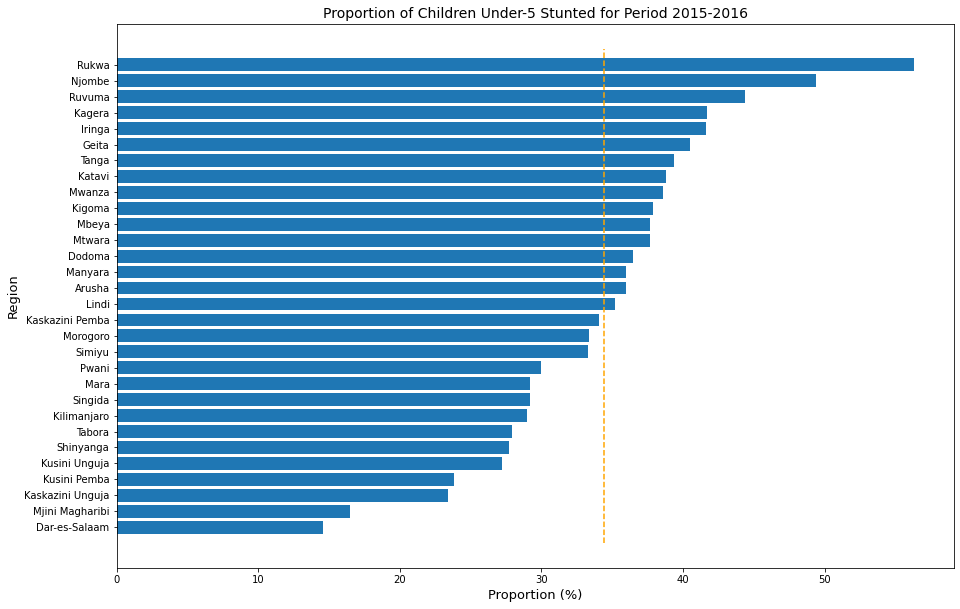

In [630]:
y1516 = u5_stunt_total_by_region["Time Period"]=="2015-2016"
plt.figure(figsize=(15,10))
plt.barh(y = u5_stunt_total_by_region.loc[y1516]["Area"],
         width = u5_stunt_total_by_region.loc[y1516]["Data Value"])
plt.vlines(x=34.4, ymin=-1, ymax=30, colors="orange", linestyles="--")
plt.title("Proportion of Children Under-5 Stunted for Period 2015-2016", fontsize=14)
plt.xlabel("Proportion (%)", fontsize=13)
plt.ylabel("Region", fontsize=13);

> For the period 2015-2016, about 1/3 (34.4%) of the children under-5 nationalwide are stunted as indicated by the orange, dashed verticle line. The situation is worst for regions such as Rukwa and Njombe where every other children under-5 is stunted.

#### 6.2.4. Children under-5 years wasted

In [585]:
u5_waste = tanz["Indicator"] == "Children under-5 years wasted"
u5_waste_df = tanz[u5_waste]
u5_waste_df.head()

,Indicator,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
4179,Children under-5 years wasted,Percent,Middle wealth quintile,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,2.5,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4180,Children under-5 years wasted,Percent,No education,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,3.2,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4181,Children under-5 years wasted,Percent,Other urban areas,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,2.4,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4182,Children under-5 years wasted,Percent,Other urban areas,Mainland,TZA001,2004-2005,NBS_ TDHS (2004-2005)_2005,2.4,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4183,Children under-5 years wasted,Percent,Primary complete,Tanzania,TZA,2004-2005,NBS_ TDHS (2004-2005)_2005,3.2,"TZA_ Demographic & Health Survey, 2004-2005, N..."


In [586]:
u5_waste_df["Subgroup"].value_counts()

Total                      180
Rural                       18
Urban                       12
Female                      10
Male                        10
Other urban areas            9
No education                 5
Primary complete             5
Primary incomplete           5
Secondary+                   5
Middle wealth quintile       3
Second wealth quintile       3
Fourth wealth quintile       3
Highest wealth quintile      3
Lowest wealth quintile       3
Name: Subgroup, dtype: int64

In [600]:
#focus on subgroup = total
subgr_filter = u5_waste_df["Subgroup"]=="Total"

In [601]:
u5_waste_df["Area ID"].str.len().value_counts()

9    150
3     85
6     39
Name: Area ID, dtype: int64

In [602]:
#Area ID length of 9 are for the 30 regions
#focus on those
area_filter = u5_waste_df["Area ID"].str.len()==9

In [603]:
u5_waste_total_by_region = u5_waste_df[subgr_filter & area_filter]
u5_waste_total_by_region.head()

,Indicator,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
4189,Children under-5 years wasted,Percent,Total,Ruvuma,TZA001010,2004-2005,NBS_ TDHS (2004-2005)_2005,0.4,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4190,Children under-5 years wasted,Percent,Total,Iringa,TZA001011,2004-2005,NBS_ TDHS (2004-2005)_2005,1.4,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4191,Children under-5 years wasted,Percent,Total,Mbeya,TZA001012,2004-2005,NBS_ TDHS (2004-2005)_2005,1.5,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4192,Children under-5 years wasted,Percent,Total,Singida,TZA001013,2004-2005,NBS_ TDHS (2004-2005)_2005,5.2,"TZA_ Demographic & Health Survey, 2004-2005, N..."
4193,Children under-5 years wasted,Percent,Total,Arusha,TZA001002,2004-2005,NBS_ TDHS (2004-2005)_2005,3.4,"TZA_ Demographic & Health Survey, 2004-2005, N..."


In [604]:
u5_waste_total_by_region["Time Period"].value_counts()

2015-2016    30
2014         30
2010         26
2004-2005    21
1991-1992    20
1996         20
2010-2011     1
2012-2013     1
2008-2009     1
Name: Time Period, dtype: int64

In [615]:
u5_waste_total_by_region = u5_waste_total_by_region.sort_values(by="Data Value")

In [631]:
u5_waste_df[(u5_waste_df["Subgroup"]=="Total") & (u5_waste_df["Time Period"]=="2015-2016") & (u5_waste_df["Area ID"]=="TZA")]
#national average for the year 2015-2016 is 4.5%

,Indicator,Unit,Subgroup,Area,Area ID,Time Period,Source,Data Value,Footnotes
7683,Children under-5 years wasted,Percent,Total,Tanzania,TZA,2015-2016,NBS_ TDHS (2015-2016)_2016,4.5,"TZA_ Demographic & Health Survey, 2015-2016, N..."


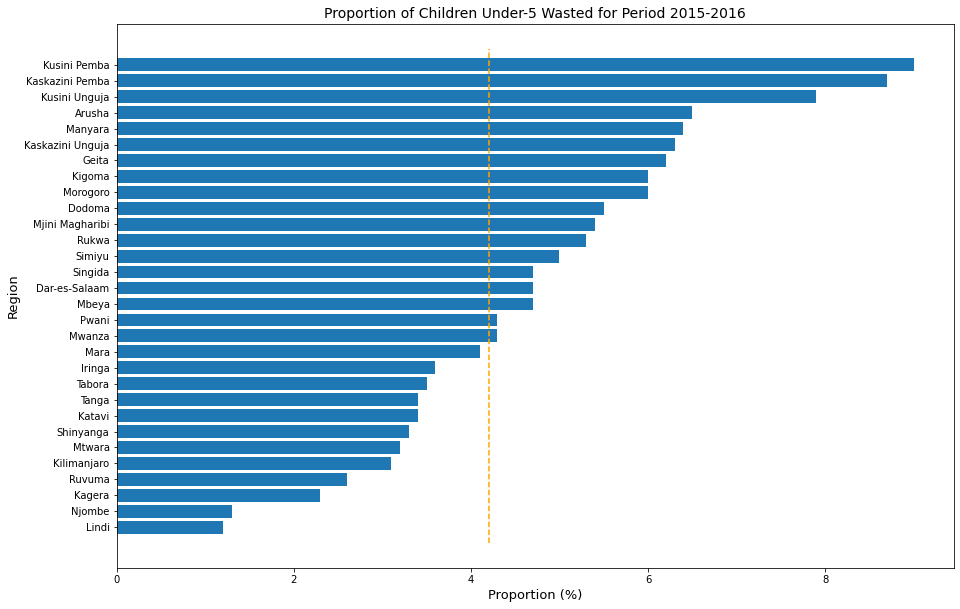

In [632]:
y1516 = u5_waste_total_by_region["Time Period"]=="2015-2016"
plt.figure(figsize=(15,10))
plt.barh(y = u5_waste_total_by_region.loc[y1516]["Area"],
         width = u5_waste_total_by_region.loc[y1516]["Data Value"])
plt.vlines(x=4.2, ymin=-1, ymax=30, colors="orange", linestyles="--")
plt.title("Proportion of Children Under-5 Wasted for Period 2015-2016", fontsize=14)
plt.xlabel("Proportion (%)", fontsize=13)
plt.ylabel("Region", fontsize=13);

> For the period 2015-2016, 4.2% of the children under-5 nationalwide are wasted as indicated by the orange, dashed verticle line. The situation is worst for regions such as Kusini Pemba, Kaskazini Pemba, Kusini Unguja where about 8% children under-5 is wasted.
>
> The situation with stunting seems much worst. Maybe we should focus on stunting only.

### 6.3. Any Other Indicators of Interest

> Population: size, growth rate, density?

In [487]:
tanz["Indicator"].value_counts()[lambda x : x.index.str.lower().str.contains("population")][:25]

Population size                                                                                1801
Population 15-49 years who know that a healthy looking person can have AIDS                     207
Population 15-49 years who have been tested for HIV                                             178
Population 15-49 years who have had 2 or more sex partners in the past 12 months                168
Population 15-49 years who believe a female HIV positive teacher should be allowed to teach     164
Population annual growth rate                                                                   149
Population density                                                                              145
Population 15-49 years circumcised                                                              140
Projected population size                                                                       130
Population with access to piped or protected water as their main source in regional centres     128


In [506]:
pop_size = tanz["Indicator"]=="Population size"
subgr_total = tanz["Subgroup"]=="Total"
year2012 = tanz["Time Period"]=="2012"

cols_to_drop = ["Indicator", "Unit", "Subgroup", "Time Period", "Source", "Footnotes"]
pop_df = tanz[(pop_size) & (subgr_total) & (year2012)].drop(columns=cols_to_drop)
pop_df.head()

,Area,Area ID,Data Value
55658,Hai,TZA001003005,210533.0
55659,Moshi Manispaa,TZA001003006,184292.0
55660,Siha,TZA001003007,116313.0
55661,Tanga,TZA001004,2045205.0
55662,Lushoto,TZA001004001,492441.0


In [542]:
pop_df["Area ID"].str.len().value_counts()

12    169
9      30
6       2
3       1
Name: Area ID, dtype: int64

>The shorter Area ID, the bigger the region
>
>Area ID = TZA is Tanzania as a whole
>
>It then breaks down into Mainland (TZA001) and Zanzibar (TZA002)
>
>Mainland and Zanzibar further break down into smaller areas
>
>Area ID TZA001xxx belongs to Mainland, Area ID TZA002xxx belongs to Zanzibar (island)

In [543]:
pop_df[pop_df["Area ID"].str.len()==3]
#country as a whole

,Area,Area ID,Data Value
55712,Tanzania,TZA,44928923.0


In [544]:
pop_df[pop_df["Area ID"].str.len()==6]
#country = Mainland + Zanzibar (island)

,Area,Area ID,Data Value
55713,Mainland,TZA001,43625354.0
55870,Zanzibar,TZA002,1303569.0


In [683]:
pop_by_area_df = pop_df[pop_df["Area ID"].str.len()==9].sort_values(by = "Area ID")
pop_by_area_df
#Mainland = 25 smaller regions
#Zanzibar = 5 smaller regions
#The population by region might be useful

,Area,Area ID,Data Value
55714,Dodoma,TZA001001,2083588.0
55722,Arusha,TZA001002,1694310.0
55730,Kilimanjaro,TZA001003,1640087.0
55661,Tanga,TZA001004,2045205.0
55736,Morogoro,TZA001005,2218492.0
55744,Pwani,TZA001006,1098668.0
55760,Dar-es-Salaam,TZA001007,4364541.0
55710,Lindi,TZA001008,864652.0
55769,Mtwara,TZA001009,1270854.0
55777,Ruvuma,TZA001010,1376891.0


In [549]:
pop_by_area_df["Data Value"].sum()

44928923.0

In [523]:
pop_df[pop_df["Area"]=="Tanzania"]

,Area,Area ID,Data Value
55712,Tanzania,TZA,44928923.0
